This notebook: 
- demonstrates web-scraping, data cleansing, and data integration,
- leverages Pandas, NumPy, and Matplotlib libraries,
- accesses public supplier and contract information available at tenders.gov.au


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Read HTML from URL, containing list of suppliers for an ICT Panel

In [7]:
t = pd.read_html('https://www.tenders.gov.au/?event=public.SON.view&SONUUID=7A6BD483-91A0-5927-C7044D04D7E413EB', attrs={'class': 'genT'}, header=0)
suppliers_df = t[0]
suppliers_df.index = suppliers_df.ABN
suppliers_df.drop('ABN', axis=1, inplace=True)
print('Suppliers: ' + str(suppliers_df.shape[0]))

Suppliers: 204


Define function to extract contract information for each supplier

In [8]:
contracts = []

def getContracts(ABN):
    #print(ABN)
    current_url = 'https://www.tenders.gov.au/?event=public.CN.searchDownload&download=true&atmtype=archived%2Cclosed%2Cpublished%2Cproposed&keywordtypesearch=AllWord&postcode=&valuefrom=&datestart=&keyword=&contractto=&suppliername=&valueto=&category=&cnid=&agencyuuid=&orderBy=Relevance&type=cnSearchEvent&portfoliouuid=&dateend=&publishfrom=&supplierabn=' + ABN.replace(' ', '') + '&datetype=current&agencyrefid=&contractfrom=&atmid=&consultancy=&agencyStatus=&numagencystatus=%2D1&publishto=&multype=archived%2Cclosed%2Cpublished'
    
    current_ABN_contracts_df = (
        pd.read_csv(current_url, 
                skiprows=16, 
                delimiter='\t',
                parse_dates=['Contract Start Date', 'Contract End Date']
               )
    )
    
    current_ABN_contracts_df['ABN'] = ABN
    

    #print('ABN: ' + ABN + ' Contracts: ' + str(current_ABN_contracts_df.shape[0]))
    contracts.append(current_ABN_contracts_df)
        
    

Loop through suppliers and extract their contract information.
After this was performed once, the results were saved to CSV format and can be read locally.

In [27]:
#for r in suppliers_df.iterrows():
#    getContracts(str(r[0]))

#contracts_df = pd.concat(c for c in contracts)

#contracts_df['CN ID'] = contracts_df['CN ID'].str.replace('=', '').str.replace('"', '')
#contracts_df['Agency'] = contracts_df['Agency'].str.replace('=', '').str.replace('"', '')
#contracts_df['Category'] = contracts_df['Category'].str.replace('=', '').str.replace('"', '')
#contracts_df['Supplier Name'] = contracts_df['Supplier Name'].str.replace('=', '').str.replace('"', '')

#contracts_df.index = contracts_df['CN ID']
#contracts_df.drop(['CN ID', 'Publish Date', 'ATM ID', 'LastUpdated', 'Unnamed: 11'], axis=1, inplace=True)

#contracts_df.to_csv('./Downloads/ICTSupplierContracts.csv', encoding='utf-8')
contracts_df = (
        pd.read_csv('./Downloads/ICTSupplierContracts.csv', 
                    encoding='utf-8', 
                    parse_dates=['Contract Start Date', 'Contract End Date'],
                    index_col='CN ID'
                   
                   )
    )


Remove the NA/Null records without nuance.

In [28]:
contracts_df_clean = contracts_df.dropna()


contracts_df_clean.shape

(8687, 8)

Add some calculations to the dataset

In [29]:
contracts_df_clean.loc[:,'Contract Months'] = ((contracts_df_clean['Contract End Date'] - contracts_df_clean['Contract Start Date']) / np.timedelta64(1, 'M')).astype(int)
contracts_df_clean.loc[:,'Value Per Month'] = (contracts_df_clean['Value (AUD)'] / contracts_df_clean['Contract Months'])

C:\Users\user\Anaconda3\lib\site-packages\pandas\core\indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\user\Anaconda3\lib\site-packages\pandas\core\indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [30]:
contracts_df_clean.head()

Title  \
CN ID                                            
CN3428944     PC Refresh installation services   
CN3374440                            Computers   
CN3370704                      ICT contractors   
CN3311938-A1                      ICT services   
CN3294934                      ICT contractors   

                                               Agency  \
CN ID                                                   
CN3428944     Australian Financial Security Authority   
CN3374440                       Department of Defence   
CN3370704               Department of Social Services   
CN3311938-A1            Department of Social Services   
CN3294934               Department of Social Services   

                                  Category Contract Start Date  \
CN ID                                                            
CN3428944                Computer services          2017-06-08   
CN3374440                        Computers          2016-08-26   
CN3370704                Computer services          2016-08-22   
CN3311938-A1  Temporary personnel services          2016-01-11   
CN3294934                Computer services          2015-10-01   

             Contract End Date  Value (AUD)  \
CN ID                                         
CN3428944           2017-06-30    104620.95   
CN3374440           2017-06-30     65488.30   
CN3370704           2017-08-21    275616.00   
CN3311938-A1        2017-06-30    404395.00   
CN3294934           2017-06-30    603240.00   

                                  Supplier Name             ABN  \
CN ID                                                             
CN3428944              4DataHall 1 P/L TA 4Data  51 137 899 346   
CN3374440                                 4DATA  51 137 899 346   
CN3370704     A & A Testing Consultants Pty Ltd  95 127 484 904   
CN3311938-A1  A & A Testing Consultants Pty Ltd  95 127 484 904   
CN3294934     A & A Testing Consultants Pty Ltd  95 127 484 904   

              Contract Months  Value Per Month  
CN ID                                           
CN3428944                   0              inf  
CN3374440                  10     6.548830e+03  
CN3370704                  11     2.505600e+04  
CN3311938-A1               17     2.378794e+04  
CN3294934                  20     3.016200e+04

In [31]:
contracts_df_clean.info()


<class 'pandas.core.frame.DataFrame'>
Index: 8687 entries, CN3428944 to CN3338630
Data columns (total 10 columns):
Title                  8687 non-null object
Agency                 8687 non-null object
Category               8687 non-null object
Contract Start Date    8687 non-null datetime64[ns]
Contract End Date      8687 non-null datetime64[ns]
Value (AUD)            8687 non-null float64
Supplier Name          8687 non-null object
ABN                    8687 non-null object
Contract Months        8687 non-null int32
Value Per Month        8687 non-null float64
dtypes: datetime64[ns](2), float64(2), int32(1), object(5)
memory usage: 712.6+ KB


In [32]:
contracts_df_clean[['ABN', 'Title']].groupby('ABN').count().sort_values(by=['Title'], ascending=False).head()

Title
ABN                  
47 001 407 281   1210
31 010 545 267    438
46 003 855 561    380
95 121 819 305    364
35 004 609 616    345

In [90]:
contracts_df_clean[contracts_df_clean.ABN == '31 010 545 267'].shape
contracts_df_clean[contracts_df_clean.ABN == '47 001 407 281'].shape

(1186, 10)

AttributeError: Unknown property kind

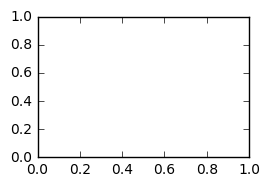

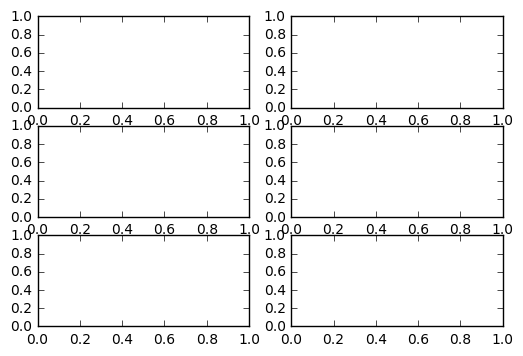

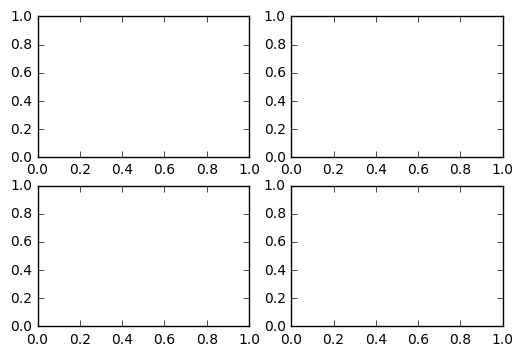

In [93]:
fig = plt.figure()
fig.add_axes()
a = fig.add_subplot(222)

fig, b = plt.subplots(nrows=3, ncols=2)

ax = plt.subplots(2, 2)
